In [1]:
# Allow reload of objects
%load_ext autoreload
%autoreload
from system import System
from experiments.readout import Experiment

# Official modules
import numpy as np
import nxsdk.api.n2a as nx
import matplotlib.pyplot as plt

In [2]:
# Initilizes the system
sys = System()

# Initilizes the experiment
inExp = Experiment()

In [3]:
inExp.trainSequence()

in-in connections deactivated


/home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


INFO:DRV:  Connecting to 134.76.92.25:32847
INFO:DRV:      Host server up..............Done 0.02s
INFO:DRV:      Encoding axons/synapses.....Done 0.67s
INFO:DRV:      Compiling Embedded snips....Done 0.10s
INFO:DRV:      Booting up..................Done 1.15s
INFO:DRV:      Encoding probes.............Done 0.24s
INFO:DRV:      Transferring probes.........Done 0.21s
INFO:DRV:      Transferring spikes.........Done 0.10s
INFO:DRV:      Configuring registers.......Done 0.87s
INFO:DRV:      Executing...................Done 119.45s
INFO:DRV:      Processing timeseries.......Done 7.41s
INFO:DRV:  Executor: 1300 timesteps........Done 130.66s


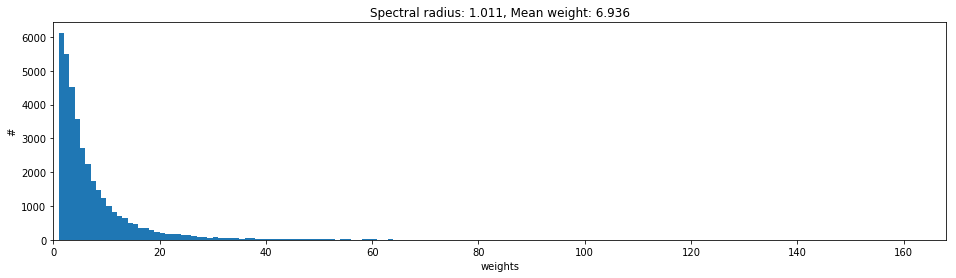

In [4]:
# Initial distribution
inExp.trainNet.plot.initialExWeightDistribution()

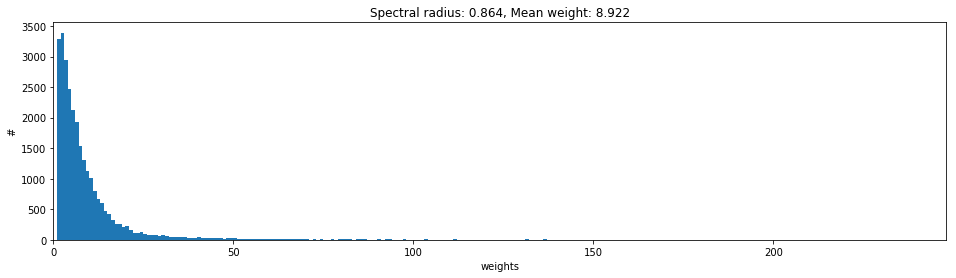

In [5]:
# Trained distribution
inExp.trainNet.plot.trainedExWeightDistribution()

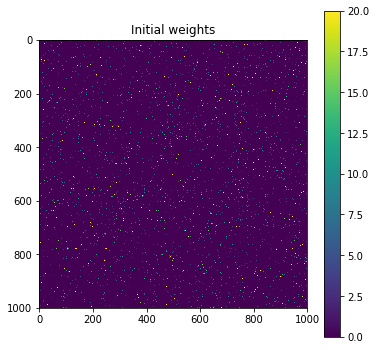

In [6]:
# Initial weight matrix
inExp.trainNet.plot.initialExWeightMatrix()

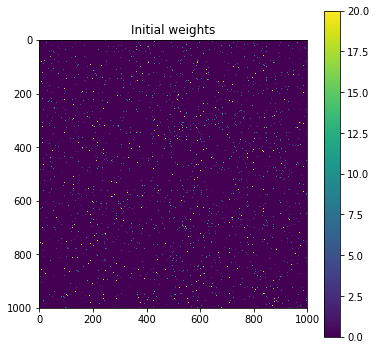

In [7]:
# Trained weight matrix
inExp.trainNet.plot.trainedExWeightMatrix()

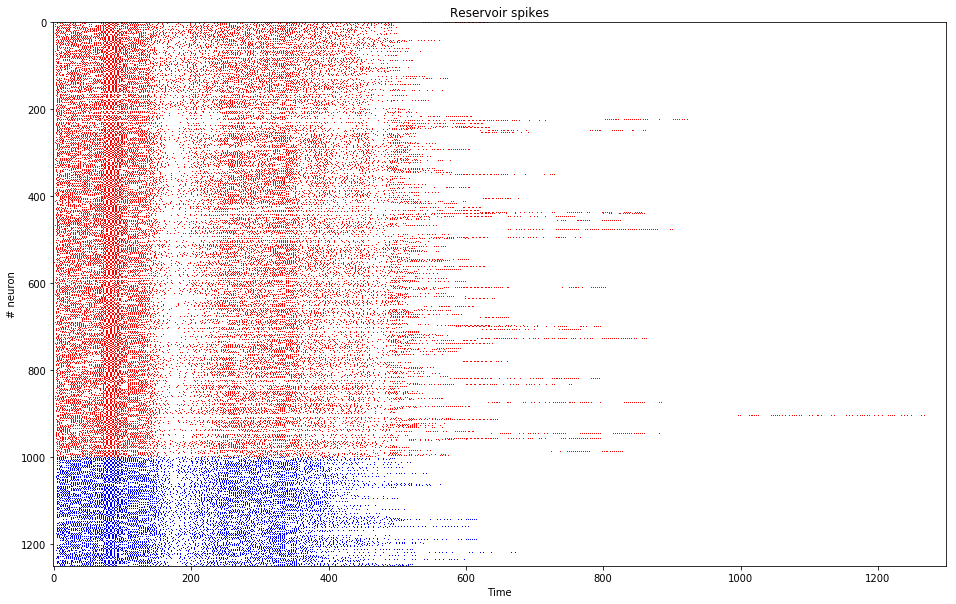

In [8]:
inExp.trainNet.plot.reservoirSpikeTrain()

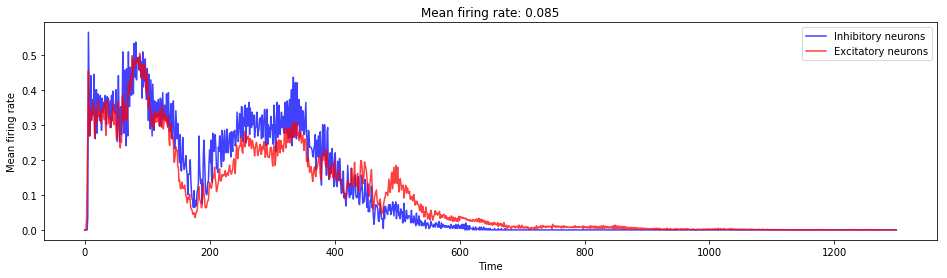

In [9]:
inExp.trainNet.plot.reservoirRates()

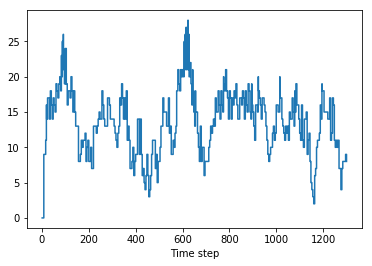

In [10]:
inExp.trainNet.reservoirTraceProbesX1[0][0].plot()